This notebook will make plots of the emu accuracy and compare it to the other error estimates. 

Considering how I want to make these. I am currently leaning toward showing fractional accuracy against the test sample. Could also show the covmats/etc but not worried about that RN. 

I also am considering showing the emu prediction of the test sample I had shown, or even a fit to it? Dunno if thats necessary. 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
#sns.set()
#import matplotlib.colors as colors
sns.set_palette('deep')
plt.rcParams.update({'font.size': 18})

In [2]:
import numpy as np
from pearce.emulator import LemonPepperWet
from glob import  glob
from os import path

 /u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


In [3]:
current_palette = sns.color_palette()
model_color_map = {'HOD': (current_palette[0], "GnBu_d"),
                    'HSAB': (current_palette[1], "YlGn_d"),
                   'SHAM': (current_palette[2], "OrRd_d"),
                   'CAB': (current_palette[3], "RdPu_d"),
                   'CorrAB': (current_palette[4], "YlOrBr_d"),
                    'Halos': (current_palette[5], 'PuBu_d')}

In [4]:
models = ['CAB', 'CorrAB', 'HSAB', 'HOD']

In [6]:
accs = np.zeros((4,2,18))
errs = np.zeros((4,2,18))
for j,obs in enumerate(['wp', 'ds']):
    all_fnames = sorted(glob('/u/ki/swmclau2/des/Aemulators/%s_*_h/*.hdf5'%obs))
    test_fnames, train_fnames = [],[]

    for f in all_fnames:
        if 'conc' in f:
            continue
        if 'test' in f:
            test_fnames.append(f)
        else:
            train_fnames.append(f)
    

    for i, (train_fname, test_fname) in enumerate(zip(train_fnames, test_fnames)):
        print train_fname, test_fname
        #print
        try:
            emu = LemonPepperWet(train_fname, fixed_params = {'z':0.0})
        except:
            continue
        break
        #print train_fname, test_fname
        pred_y, data_y = emu.goodness_of_fit(test_fname, statistic=None)
        
        #print data_y, pred_y
        accs[i,j] = (np.abs(10**pred_y-10**data_y)/np.abs(10**data_y)).mean(axis=1)
        errs[i,j] = np.mean((10**pred_y-10**data_y)**2, axis=1)
        #print '*'*30


/u/ki/swmclau2/des/Aemulators/wp_cab_h/PearceWpCABCosmo.hdf5 /u/ki/swmclau2/des/Aemulators/wp_cab_test_h/PearceWpCABCosmoTest.hdf5
/u/ki/swmclau2/des/Aemulators/wp_corrab_h/PearceWpCorrABCosmo.hdf5 /u/ki/swmclau2/des/Aemulators/wp_corrab_test_h/PearceWpCorrABCosmoTest.hdf5
/u/ki/swmclau2/des/Aemulators/ds_cab_h/PearceDsCABCosmo.hdf5 /u/ki/swmclau2/des/Aemulators/ds_cab_test_h/PearceDsCABCosmoTest.hdf5


In [7]:
param_names = emu.get_param_names()
param_bounds = [emu.get_param_bounds(p) for p in param_names]
random_point = [np.random.uniform(l,h) for l,h in param_bounds]
point = dict(zip(param_names, random_point))

In [12]:
%%timeit 
emu.emulate_wrt_r(point)

The slowest run took 6.03 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 6.8 ms per loop


In [39]:
full_cov = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/wp_ds_full_covmat_h.npy')#, full_cov[:36][:, :36])
#np.save('/home/users/swmclau2/Git/pearce/bin/covmat/wp_full_covmat.npy', full_cov[:18][:, :18])
#np.save('/home/users/swmclau2/Git/pearce/bin/covmat/ds_full_covmat.npy', full_cov[18:36][:, 18:36])
cov = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/wp_ds_sim_covmat_h.npy')#, cov[:36][:, :36])

In [53]:
error = np.sqrt(np.diag(cov)).reshape((-1,2), order ='F')
shape_error =  np.sqrt(np.diag(full_cov-cov)).reshape((-1,2), order ='F')

In [41]:
#emu covs
emu_cov_fnames = ['/u/ki/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov_lpw.npy',
                  '/u/ki/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov_lpw.npy']

In [42]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [43]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

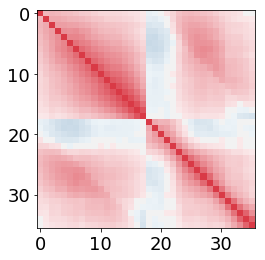

In [44]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)
plt.imshow(cov_to_corr(cov), cmap = cmap, vmin = -1)

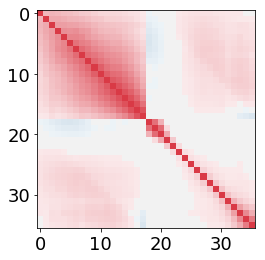

In [45]:
plt.imshow(cov_to_corr(full_cov), cmap = cmap, vmin = -1)

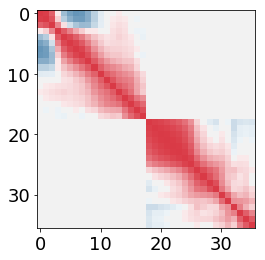

In [46]:
plt.imshow(cov_to_corr(emu_cov), cmap = cmap, vmin = -1)

In [47]:
emu_err = np.sqrt(np.diag(emu_cov)).reshape((-1,2), order = 'F')

In [48]:
avg_ys = []
for j,obs in enumerate(['wp', 'ds']):
    train_fname = glob('/u/ki/swmclau2/des/Aemulators/%s_zheng07_h/*.hdf5'%obs)[0]
    emu = LemonPepperWet(train_fname, fixed_params = {'z':0.0})
    avg_ys.append(10**(emu.y.mean(axis=(0,1))+emu._y_mean) )

In [49]:
models2 = sorted(['hod', 'hsab', 'cab', 'corrab'])

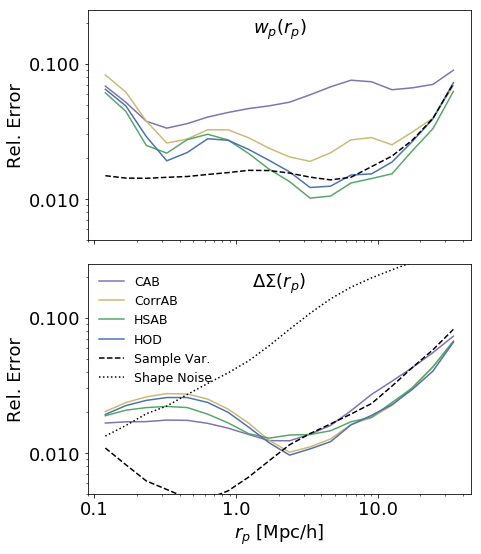

In [71]:
import matplotlib.ticker as mticker

fig, axes = plt.subplots(2,1, figsize = (7,2*4), sharex=True)
emu_cov_fname = '/u/ki/swmclau2/Git/pearce/bin/optimization/%s_%s_emu_cov_lpw.npy'
for i, (model, model_lc) in enumerate(zip(models, models2)):
    for j, obs in enumerate(['wp', 'ds']):
        emu_err = np.sqrt(np.diag(np.load(emu_cov_fname%(obs, model_lc))))

        #axes[j].plot(emu.scale_bin_centers, np.sqrt(errs[i,j]), color = model_color_map[model][0], label = model)
        axes[j].plot(emu.scale_bin_centers, emu_err/(avg_ys[j]), 
                     color = model_color_map[model][0], label = model)
        axes[j].set_ylim([0.005, 0.25])
        axes[j].loglog();
        axes[j].set_ylabel('Rel. Error')
        axes[j].yaxis.set_major_formatter(mticker.ScalarFormatter())

axes[0].text(.5,.9, r'$w_p(r_p)$',
                horizontalalignment='center',
                transform=axes[0].transAxes)
axes[1].text(.5,.9, r'$\Delta \Sigma(r_p)$',
                horizontalalignment='center',
                transform=axes[1].transAxes)

for i,obs in enumerate(['wp', 'ds']):
    axes[i].plot(emu.scale_bin_centers, error[:,i]/(avg_ys[i]),
                  color = 'k', ls ='--', label = 'Sample Var.')
    
axes[1].plot(emu.scale_bin_centers, np.sqrt(shape_error[:,1])/avg_ys[1],
             color ='k', ls =':', label ='Shape Noise')
#axes[0].legend(loc='best', frameon=False,fontsize='x-small')

axes[1].legend(loc=2, frameon=False,fontsize='x-small')

axes[1].set_xlabel(r'$r_p$ [Mpc/h]')
axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
fig.tight_layout()
plt.savefig('emu_acc.pdf', format='pdf')